In [1]:
!git clone https://github.com/rajat-1994/SuperResolution-with-Perceptual-loss.git

Cloning into 'SuperResolution-with-Perceptual-loss'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.


In [2]:
!ls

sample_data  SuperResolution-with-Perceptual-loss


In [3]:
cd SuperResolution-with-Perceptual-loss/

/content/SuperResolution-with-Perceptual-loss


In [4]:
!ls

LICENSE  README.md  sr_2x.h5  SR-2X.ipynb  train_data.csv


In [5]:

!pip uninstall scipy

Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.4.1


In [6]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [7]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import importlib
import tensorflow as tf
import tensorflow.keras as K
import math, datetime, pandas as pd, numpy as np
import matplotlib.pyplot as plt,random, pickle, glob, os
import sklearn
from PIL import Image
import tarfile
import cv2
import random

## Loading data

Download and extract training data by uncommenting below cell

In [8]:
!wget http://files.fast.ai/data/imagenet-sample-train.tar.gz
fname='imagenet-sample-train.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

--2020-01-18 17:58:55--  http://files.fast.ai/data/imagenet-sample-train.tar.gz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2232645974 (2.1G) [application/gzip]
Saving to: ‘imagenet-sample-train.tar.gz’

imagenet-sample-tra 100%[===================>]   2.08G  37.8MB/s    in 23s     

2020-01-18 17:59:19 (92.4 MB/s) - ‘imagenet-sample-train.tar.gz’ saved [2232645974/2232645974]



In [0]:
input_size=64

In [0]:
# path='train/'

# img_list = glob.glob(path+'**/*.JPEG', recursive=True)
# n = len(img_list); n

In [11]:
train_df=pd.read_csv('train_data.csv')
train_df.shape

(2152, 3)

In [12]:
train_list=train_df.ids
len(train_list)

2152

In [13]:
!git clone https://github.com/niazwazir/SET5_BMP.git

Cloning into 'SET5_BMP'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [14]:
!ls

imagenet-sample-train.tar.gz  README.md  sr_2x.h5     train
LICENSE			      SET5_BMP	 SR-2X.ipynb  train_data.csv


In [15]:
val_list = glob.glob('SET5_BMP/*.*', recursive=True)
len(val_list)

5

In [0]:
def read_image(img_path,scale=2):
    global input_size
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lr = cv2.resize(img, (input_size,input_size),interpolation=cv2.INTER_CUBIC)
    img_hr = cv2.resize(img, (input_size*scale,input_size*scale),interpolation=cv2.INTER_CUBIC)
    return img_lr,img_hr


(128, 128, 3)


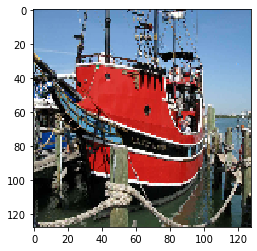

In [17]:
_,img=read_image(train_list[800])
print(img.shape)
plt.imshow(img)

(128, 128, 3)


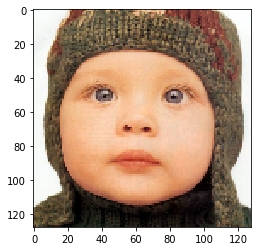

In [18]:
_,img=read_image(val_list[0])
print(img.shape)
plt.imshow(img)

## Super Resolution Model

In [0]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [0]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [0]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [0]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [23]:
inp,outp=get_srmodel((None,None,3))
sr_model=K.Model(inp,outp)
sr_model.summary(110)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                [(None, None, None, 3)] 0                                                 
______________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, None, None, 16)  448          input_1[0][0]                        
______________________________________________________________________________________________________________
activation (Activation)             (None, None, None, 16)  0            conv2d[0][0]                         
______________________________________________________________________________________________________________
conv2d_1 (Conv2D

### loading vgg for calculating perceptual loss from one of its layer

In [25]:
vgg_inp=K.Input(shape=outp.shape[1:])
vgg= K.applications.VGG16(include_top=False, 
                                  input_tensor=vgg_inp)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
for l in vgg.layers: l.trainable=False

In [0]:
# preproc_layer = K.layers.Lambda(preproc)

In [28]:
#Here we are using vgg layer at index 36 to be the layer to calculate loss between Traget and predicted image
vgg_out_layer = vgg.get_layer(index=5).output

# making model Model(inputs, outputs)
vgg_content = K.Model(vgg_inp, vgg_out_layer)

vgg_content.summary(110)

Model: "model_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
input_2 (InputLayer)                             [(None, None, None, 3)]                     0                
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)                            (None, None, None, 64)                      1792             
______________________________________________________________________________________________________________
block1_conv2 (Conv2D)                            (None, None, None, 64)                      36928            
______________________________________________________________________________________________________________
block1_pool (MaxPooling2D)                       (None, None, None, 64)                      0 

## Data Generator and Metrics

In [0]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [0]:
def randomCrop(img):
  global input_size
  h=input_size*2
  assert img.shape[0] >= h
  assert img.shape[1] >= h
  x = random.randint(0, img.shape[1] - h)
  y = random.randint(0, img.shape[0] - h)
  img = img[y:y+h, x:x+h]
  return img

In [0]:
batch_size = 16

In [0]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [0]:
l=next(valid_generator())

In [0]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

In [0]:
# This is our perceptual loss function
def perceptual_loss(y_true,y_pred):
#     mse=K.losses.mean_squared_error(y_true,y_pred)
    y_t=vgg_content(y_true)
    y_p=vgg_content(y_pred)
    loss=K.losses.mean_squared_error(y_t,y_p)
    return loss

In [0]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
sr_model.compile(optimizer=adam,loss=perceptual_loss,metrics=[psnr,ssim])

In [0]:
batch_size=16
input_size=32

In [0]:
def fit(model,epoch=2):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [39]:
sr_model=fit(sr_model,2)

Epoch 1/2
135/135 [==============================] - 21s 154ms/step - loss: 8.0458 - psnr: 16.9365 - ssim: 0.5258 - val_loss: 9.0806 - val_psnr: 17.9287 - val_ssim: 0.5713
Epoch 2/2
135/135 [==============================] - 12s 85ms/step - loss: 5.0000 - psnr: 19.0836 - ssim: 0.5951 - val_loss: 8.5586 - val_psnr: 18.2814 - val_ssim: 0.5843


progressive resizing

In [0]:
# input_size=64
# sr_model=fit(sr_model,15)

In [0]:
# input_size=96
# sr_model=fit(sr_model,10)

In [0]:
# input_size=128
# sr_model=fit(sr_model,15)

In [43]:
input_size=160
sr_model=fit(sr_model,2)

Epoch 1/2
135/135 [==============================] - 57s 420ms/step - loss: 2.2797 - psnr: 24.2326 - ssim: 0.7374 - val_loss: 0.8790 - val_psnr: 27.3182 - val_ssim: 0.8226
Epoch 2/2
135/135 [==============================] - 52s 385ms/step - loss: 2.2187 - psnr: 24.5385 - ssim: 0.7446 - val_loss: 0.8294 - val_psnr: 27.6808 - val_ssim: 0.8318


In [44]:
input_size=224
sr_model=fit(sr_model,2)

Epoch 1/2
135/135 [==============================] - 112s 831ms/step - loss: 1.5875 - psnr: 26.7003 - ssim: 0.8068 - val_loss: 0.3417 - val_psnr: 30.9872 - val_ssim: 0.8907
Epoch 2/2
135/135 [==============================] - 101s 749ms/step - loss: 1.5668 - psnr: 26.7356 - ssim: 0.8110 - val_loss: 0.3423 - val_psnr: 31.1225 - val_ssim: 0.8926


In [0]:
input_size=160

In [0]:
tlr,hlr=read_image(val_list[3])
tlr=np.expand_dims(tlr,axis=0)
pred=sr_model.predict(tlr/255.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


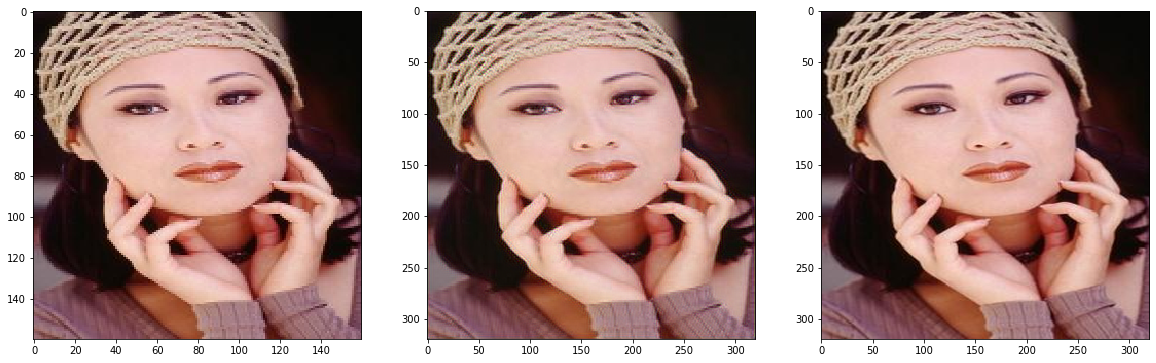

In [47]:
_,axs=plt.subplots(1,3,figsize=(20,20))
ax=axs.flat
ax[0].imshow(tlr[0]/255.)
ax[1].imshow(pred[0])
ax[2].imshow(hlr/255.)

In [0]:
K.models.save_model(sr_model,'sr_2x.h5')

In [49]:
!ls

imagenet-sample-train.tar.gz  README.md  sr_2Ax.h5  SR-2X.ipynb  train_data.csv
LICENSE			      SET5_BMP	 sr_2x.h5   train
